In [119]:
import pandas as pd
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from einops import rearrange
import requests
import io
import json
from functools import reduce
from tqdm import tqdm
from scipy.ndimage import gaussian_filter
import mediapy as media
import jax
import numpy as np
from visualization_tools import game_coord_to_pixel_coord

In [2]:
run_dir = Path('mini_agent_stats') # Path('baselines/session_ebdfe818')
# original session_e41c9eff, main session_4da05e87, extra session_e1b6d2dc

In [3]:
def path_to_runs(pth):
    tdf = pd.read_csv(pth, compression='gzip')
    return np.array_split(tdf[tdf['map'] != 'map'], 610)

In [4]:
all_runs = [path_to_runs(pth) for pth in tqdm(run_dir.glob('*.gz'))]
all_runs = list(map(list, zip(*all_runs)))

5it [01:42, 20.49s/it]


In [5]:
len(all_runs)

610

In [6]:
len(all_runs[0])

5

In [7]:
all_runs[0][0].keys()

Index(['Unnamed: 0', 'step', 'x', 'y', 'map', 'pcount', 'levels', 'ptypes',
       'hp', 'frames', 'deaths', 'badge', 'event', 'healr'],
      dtype='object')

In [8]:
poke_id_to_name = {
    177: "Squirtle",
    255: "None",
    0: "None",
    165: "Rattata",
    36: "Pidgey",
    179: "Wartortle",
    150: "Pidgeotto",
    112: "Weedle",
    113: "Kakuna",
    133: "Magikarp",
    169: "Geodude",
    107: "Zubat",
    109: "Paras",
    100: "Jigglypuff",
    84: "Pikachu",
    124: "Metapod",
    4: "Clefairy"
}
valid_list = [name for name in poke_id_to_name.values() if name != 'None']
valid_list

['Squirtle',
 'Rattata',
 'Pidgey',
 'Wartortle',
 'Pidgeotto',
 'Weedle',
 'Kakuna',
 'Magikarp',
 'Geodude',
 'Zubat',
 'Paras',
 'Jigglypuff',
 'Pikachu',
 'Metapod',
 'Clefairy']

In [13]:
# find time spent holding each pokemon
all_poke_counts = []
for run in tqdm(all_runs):
    p_counts = {p:0 for p in valid_list}
    for sim_df in run:
        caught_pokes = set()
        for step in sim_df['ptypes']:       
            party = json.loads(step)
            for p in party:
                pname = poke_id_to_name[p]
                caught_pokes.add(pname)
        for p in caught_pokes:
            if p == 'None':
                continue
            if p in p_counts.keys():
                p_counts[p] += 1
            else:
                p_counts[p] = 1
    all_poke_counts.append(p_counts)
        

100%|██████████| 610/610 [02:48<00:00,  3.63it/s]


In [14]:
all_poke_counts

[{'Squirtle': 5,
  'Rattata': 5,
  'Pidgey': 5,
  'Wartortle': 0,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Metapod': 0,
  'Clefairy': 0},
 {'Squirtle': 5,
  'Rattata': 3,
  'Pidgey': 4,
  'Wartortle': 0,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Metapod': 0,
  'Clefairy': 0},
 {'Squirtle': 5,
  'Rattata': 2,
  'Pidgey': 4,
  'Wartortle': 0,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Metapod': 0,
  'Clefairy': 0},
 {'Squirtle': 5,
  'Rattata': 4,
  'Pidgey': 3,
  'Wartortle': 0,
  'Pidgeotto': 0,
  'Weedle': 0,
  'Kakuna': 0,
  'Magikarp': 0,
  'Geodude': 0,
  'Zubat': 0,
  'Paras': 0,
  'Jigglypuff': 0,
  'Pikachu': 0,
  'Metapod': 0,
  'Clefairy': 0},
 {'Squirtle': 5,
  'Ratt

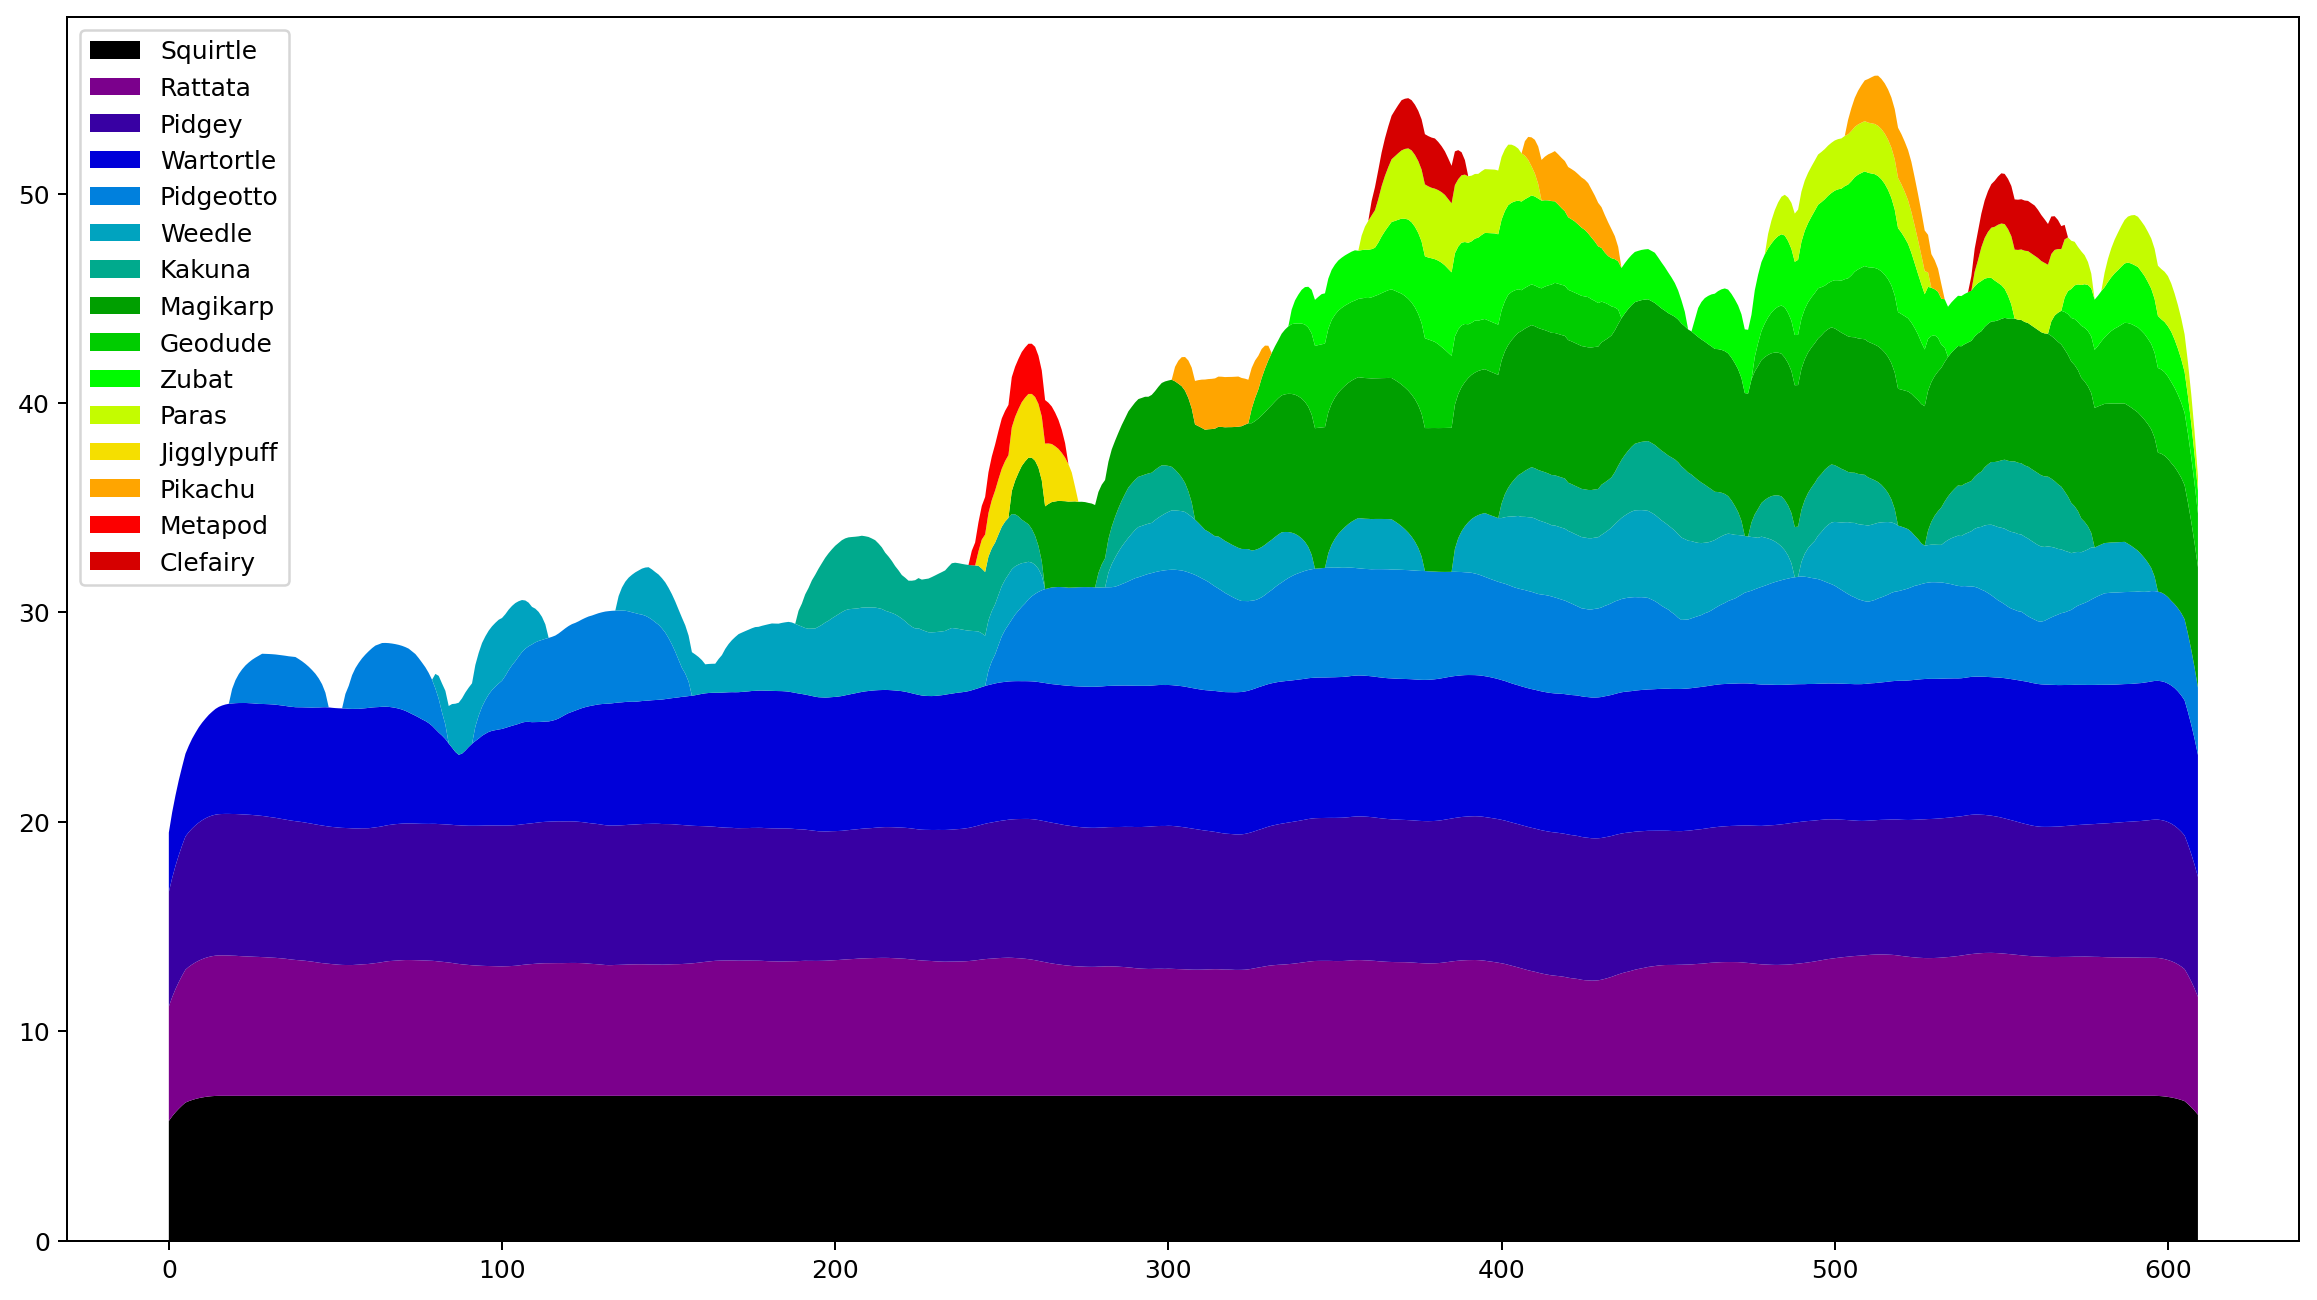

In [111]:
steps = len(all_poke_counts)
x = range(steps)
raw_counts = np.array(list(zip(*[list(counts.values()) for counts in all_poke_counts])))
raw_counts = [np.convolve(rc, np.ones(20), mode='same') for rc in raw_counts]
raw_counts = [np.log(1+np.convolve(rc, np.ones(10), mode='same')) for rc in raw_counts]
plt.figure(figsize=(16, 9), dpi=180)
cols = iter(plt.cm.nipy_spectral(np.linspace(0, 40, steps)))
plt.stackplot(x, *raw_counts, labels=valid_list, colors=cols)
plt.legend(loc='upper left')

In [9]:
base_stats = {
    'pcount': 0, 
    'total_levels': 0, 'frames': 0, 'deaths': 0, 
    'event': 0, 'healr': 0
}

In [10]:
def df_to_numpy(df):
    # load levels and sum
    df['total_levels'] = df['levels'].map(lambda x: sum(json.loads(x)))
    #df = df.drop(columns=['levels', 'ptypes', 'Unnamed: 0', 'step', ])
    #df['gcoords'] = df.apply(
    #    lambda r: fastish(r['x'], r['y'], r['map'], 4000), axis=1)
    #df['gx'] = df['gcoords'].map(lambda c: c[0])
    #df['gy'] = df['gcoords'].map(lambda c: c[1])
    # select only relevent stats and convert all to floats
    return df[base_stats.keys()].applymap(lambda v: float(v)).to_numpy()

In [11]:
df_to_numpy(all_runs[0][0]).shape

(16385, 6)

In [26]:
name_to_idx = {name:idx for idx, name in enumerate(base_stats.keys())}
name_to_idx

{'pcount': 0,
 'total_levels': 1,
 'frames': 2,
 'deaths': 3,
 'event': 4,
 'healr': 5}

In [16]:
big_dat = np.array([[df_to_numpy(run) for run in batch] for batch in tqdm(all_runs)])
#df_to_numpy(all_runs[0][0]).shape


 25%|██▌       | 155/610 [01:12<04:28,  1.70it/s]


 51%|█████     | 309/610 [02:28<01:58,  2.54it/s]


 76%|███████▌  | 463/610 [03:29<00:57,  2.54it/s]


100%|██████████| 610/610 [04:24<00:00,  2.31it/s]


In [17]:
big_dat.shape

(610, 5, 16385, 6)

In [24]:
big_dat[:,:,:,0].mean(axis=1).shape

(610, 16385)

In [141]:
rearrange(big_dat, '(r x) b s d -> r (x b) s d', x=1).shape

(610, 5, 16385, 6)

In [120]:
the_dat = 'total_levels'
steps = 100
start_step = 130
combine_steps = 5
plot_dat = rearrange(
    big_dat, '(r x) b s d -> r (x b) s d', x=combine_steps
    )[:, :, :, name_to_idx[the_dat]].mean(axis=1)
for i in range(len(plot_dat)):
    plot_dat[i] = gaussian_filter(plot_dat[i], 100.0, mode='nearest')
with media.VideoWriter(f'{the_dat}.mp4', (1080, 1920)) as wr:
    for i in tqdm(np.geomspace(start_step, plot_dat.shape[1]+1, num=steps)):
        i = int(i)
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        for idx, dat in enumerate(plot_dat[:,:i]):
            plt.plot(dat, color=plt.cm.jet(idx/plot_dat.shape[0]))

        # Number of accent colors in the color scheme
        plt.title(the_dat)
        plt.xlabel('game actions', fontsize=14)
        plt.ylabel(the_dat, fontsize=14)

        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        plt.close()

100%|██████████| 100/100 [00:31<00:00,  3.21it/s]


  2%|▏         | 2/100 [00:02<01:53,  1.16s/it]


RuntimeError: Error writing 'frames.mp4': 

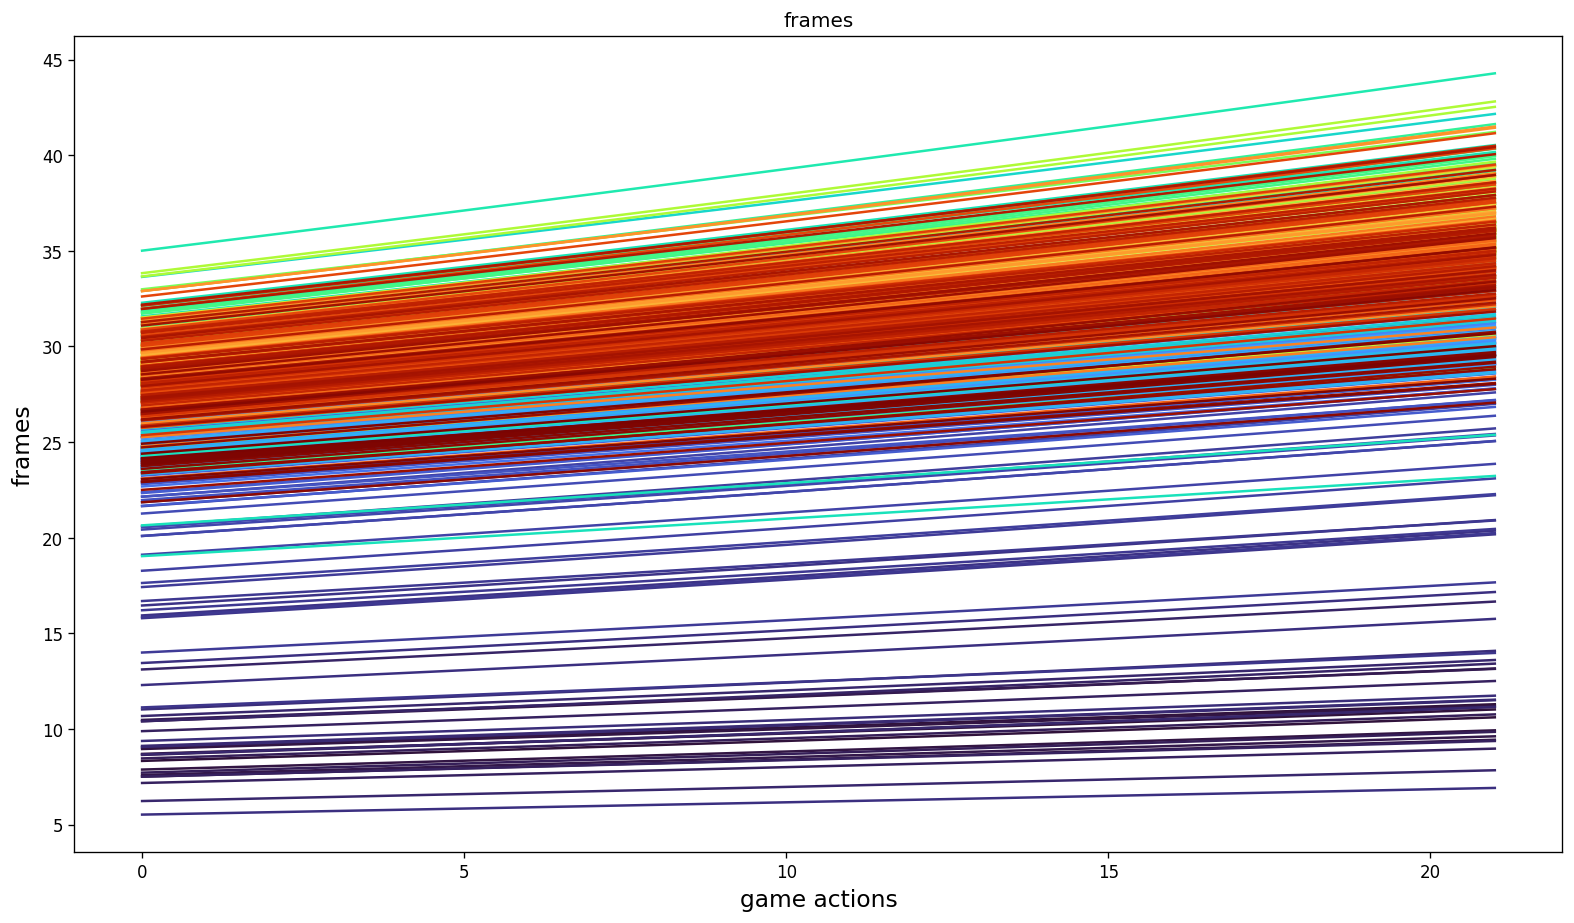

In [148]:
# this should not be decreasing!!
the_dat = 'frames'
steps = 100
start_step = 20
combine_steps = 1
plot_dat = rearrange(
    big_dat, '(r x) b s d -> r (x b) s d', x=combine_steps
    )[:, :, :, name_to_idx[the_dat]].mean(axis=1)
for i in range(len(plot_dat)):
    plot_dat[i] = gaussian_filter(plot_dat[i], 100.0, mode='nearest')
with media.VideoWriter(f'{the_dat}.mp4', (1080, 1920)) as wr:
    for i in tqdm(np.geomspace(start_step, plot_dat.shape[1]+1, num=steps)):
        i = int(i)
        #with plt.style.context('Solarize_Light2'):
        fig = plt.figure(figsize=(16, 9), dpi=120)
        for idx, dat in enumerate(plot_dat[:,:i]):
            plt.plot(dat, color=plt.cm.turbo(idx/plot_dat.shape[0]))

        # Number of accent colors in the color scheme
        plt.title(the_dat)
        plt.xlabel('game actions', fontsize=14)
        plt.ylabel(the_dat, fontsize=14)
        fig.canvas.draw()
        #plt.show()
        data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        wr.add_image(data)
        
        plt.close()

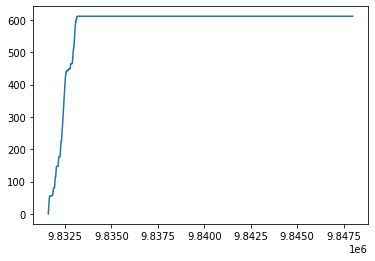

In [146]:
plt.plot(all_runs[600][0]['frames'].map(int))

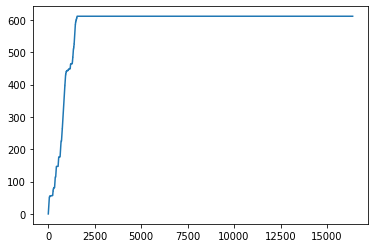

In [147]:
plt.plot(big_dat[600,0,:,2])